In [18]:
# all imports needed to run this file
import torch
import torch.nn.functional as F
from torch import nn
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, convolve
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import structural_similarity as ssm

#We check whether cuda is available and choose device accordingly
if torch.cuda.is_available()==True:
  device="cuda:0"
else:
  device ="cpu"

#### Load Traing and Test Data
The images are splitted into training and test set (7-3). All values are scaled to a range from 0 to 1.

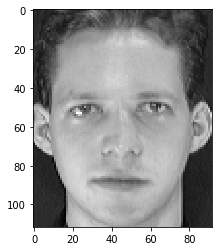

In [7]:
classes = os.listdir('./data/processed/train')
c_to_i = lambda x: classes.index(x)
i_to_c = lambda x: classes[x]

transformer = transforms.Compose([
    transforms.ToTensor(),
])

def show_img(im):
    plt.imshow(im.reshape(112, 92), cmap='gray')
    plt.show()
    
def one_hot(x):
    vec = [0] *len(classes)
    vec[x] = 1
    return vec
    
train =test= 0
train_x, train_y = ([0]) * 280, ([0]) * 280
test_x, test_y = ([0]) * 120, ([0]) * 120
asd = []

for c in os.listdir('./data/processed/train/'):
    for faces in os.listdir('./data/processed/train/'+c):
        img = np.array(Image.open('./data/processed/train/'+c+'/'+faces).convert('L'))
        train_x[train] = (img).flatten()
        train_y[train] = (c_to_i(c))
        train += 1

for c in os.listdir('./data/processed/test/'):
    for faces in os.listdir('./data/processed/test/'+c):
        img = np.array(Image.open('./data/processed/test/'+c+'/'+faces).convert('L'))
        test_x[test] = img.flatten()
        test_y[test] = (c_to_i(c))
        test += 1

train_x = np.stack([x.flatten()/255 for x in train_x])
test_x = np.stack([x.flatten()/255 for x in test_x])
test_y = np.array(test_y,  dtype=np.int64)
train_y = np.array(train_y, dtype=np.int64)

show_img(train_x[0])

#### Stacked denoising Autoencoder Network [git]( https://github.com/pranjaldatta/Denoising-Autoencoder-in-Pytorch/blob/master/DenoisingAutoencoder.ipynb )
- First transform the image via an AE with 1000 units
- Then transform the transformed image again via an AE with 300 units
(this should reduce from the image the not so common characteristics)
- Then use this double transformed image as input for the final softmax layer (which is likely the same as they have used for their first classification)
- Then try to re-create the input for for this softmax layer

The autoencoder architecture consists of two parts: encoder and decoder.

In [19]:
# dae
class DAENetwork(nn.Module):
    def __init__(self):
        super(DAENetwork, self).__init__()
        
        # first dae
        self.encoder1 = nn.Sequential(
                  nn.Linear(112*92,1000),
                  nn.Sigmoid())
        self.decoder1 = nn.Sequential(
                  nn.Linear(1000,112*92),
                  nn.Sigmoid())
        
        # second dae
        self.encoder2 = nn.Sequential(
                  nn.Linear(112*92,300),
                  nn.Sigmoid())
        self.decoder2 = nn.Sequential(
                  nn.Linear(300,112*92),
                  nn.Sigmoid())
        
    def forward(self,x):
        x = x.view(x.shape[0], -1)
        x = self.encoder1(x)
        x = self.decoder1(x)
        x = self.encoder2(x)
        x = self.decoder2(x)
        return x

# last layer
class SMNetwork(nn.Module):

    def __init__(self):
        super(SMNetwork, self).__init__()
        self.fc1 = nn.Linear(10304, 40)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.log_softmax(self.fc1(x), dim=1)
        return x

In [22]:
# train model
model = DAENetwork()
#model = model.to(device)
    
epochs = 20
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for i in range(epochs):
    # forward pass
    y_hat = model(torch.Tensor(train_x))
    loss = criterion(y_hat, torch.LongTensor(train_y))
    
    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

#### Basic MI Attack

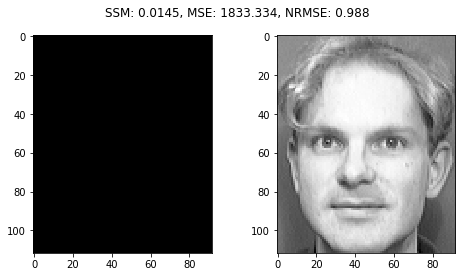

In [23]:
pred = ''
def invert(model, img, lr, c, best_loss, best_x, i):
    img = torch.Tensor(img).view(1, -1)
    if not img.requires_grad:
        img.requires_grad = True
        
    optimizer.zero_grad()
    pred = model(img)
    loss = criterion(pred, torch.LongTensor([c]))
    loss.backward()    
    img = torch.clamp(img - lr * img.grad, 0, 255)

    if loss.detach().numpy() < best_loss and i > 10:
        best_loss = loss.detach().numpy()
        best_x = img.detach().numpy()
        

    filt = np.array([
        [0,-1,0],
        [-1,5,-1],
        [0,-1,0]
    ])
    np_a = np.array([np.clip(x + np.random.normal(2, 2),0,255) for x in img.detach().numpy()])
    i = convolve(np_a.reshape(112, 92), filt)
    
    return best_loss, best_x, np_a.reshape(1, -1)
            
        
for c in classes:
    best_x,best_loss='',float('inf')
    img = np.zeros_like(train_x[0])
    for i in range(100):
        best_loss,best_x,img = invert(model, img, .01, c_to_i(c), best_loss, best_x, i)
    if c=='s34':
        rec = best_x.reshape(112, 92)
        orig = test_x[c_to_i(c)].reshape(112, 92).astype('float32')
        ssmv = ssm(rec,orig)
        msev = mse(rec,orig)
        nrmsev = nrmse(rec,orig)
        fig = plt.figure(figsize=(8, 4))
        fig.suptitle("SSM: {:.4f}, MSE: {:.3f}, NRMSE: {:.3f}".format(ssmv,msev,nrmsev))
        ax1 = fig.add_subplot(1,2,1)
        ax1.imshow(rec, cmap='gray')
        ax2 = fig.add_subplot(1,2,2)
        ax2.imshow(orig, cmap='gray')
        # plt.savefig(f'./data/results/class {c}.png')
        plt.show()